#Requerimiento: Transformaciones: columnas de fecha.

Docente : Andres Felipe callejas

Integrantes : Oscar Javier Garcia G.
              Rober Andres Castillo G.

Asignatura : Big data

Año : 07/12/2025



#Carga de datos desde el df con csv de datos crudos

# 1. Configuración y Carga de Datos

Configuramos Spark para aceptar formatos de fecha antiguos ("Legacy") y cargamos el archivo asegurándonos de usar el delimitador correcto (punto y coma).


In [0]:
%python
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# 1. Configuración: Permitir formatos de fecha antiguos (Legacy) para evitar errores
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# 2. Ruta del archivo (Asegúrate que esta sea la ruta correcta de tu volumen)
ruta = "/Volumes/workspace/Autos/archivos_csv/Venta_Autos2.csv"

# 3. Carga: Leemos el CSV definiendo el separador ";" para que las columnas no se mezclen
df_crudo = spark.read.format("csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .option("delimiter", ";") \
  .load(ruta)

df_crudo.printSchema()
display(df_crudo.limit(5))

print("Carga inicial completada.")

root
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Sales_in_thousands: integer (nullable = true)
 |-- __year_resale_value: integer (nullable = true)
 |-- Vehicle_type: string (nullable = true)
 |-- Price_in_thousands: integer (nullable = true)
 |-- Engine_size: integer (nullable = true)
 |-- Horsepower: integer (nullable = true)
 |-- Wheelbase: integer (nullable = true)
 |-- Width: integer (nullable = true)
 |-- Length: integer (nullable = true)
 |-- Curb_weight: integer (nullable = true)
 |-- Fuel_capacity: integer (nullable = true)
 |-- Fuel_efficiency: integer (nullable = true)
 |-- Latest_Launch: string (nullable = true)
 |-- Power_perf_factor: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- name: string (nullable = true)
 |-- email: string (nullable = true)



Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Country,City,State,Region,name,email
Acura,Integra,16919,1636,Passenger,215,18,140,1012,673,1724,2639,132,28,2/2/2012,5828014952,United States,Henderson,Kentucky,South,Mason Howell,jessica.cole@example.net
Acura,TL,39384,19875,Passenger,284,32,225,1081,703,1929,3517,172,25,6/3/2011,9137077766,United States,Henderson,Kentucky,South,Mason Howell,jessica.cole@example.net
Acura,CL,14114,18225,Passenger,null,32,225,1069,706,192,347,172,26,1/4/2012,null,United States,Los Angeles,California,West,Mason Howell,jessica.cole@example.net
Acura,RL,8588,29725,Passenger,42,35,210,1146,714,1966,385,18,22,3/10/2011,9138977933,United States,Fort Lauderdale,Florida,South,Mason Howell,jessica.cole@example.net
Audi,A4,20397,22255,Passenger,2399,18,150,1026,682,178,2998,164,27,10/8/2011,627776392,United States,Fort Lauderdale,Florida,South,Mason Howell,jessica.cole@example.net


Carga inicial completada.


#2. Transformación de Fechas

resolvemos el problema de los formatos mixtos. Usamos para intentar primero el formato de EE. UU. () y, si falla, el estándar. Luego creamos las columnas de año, mes y día.coalesceM/d/yyyy

In [0]:
%python
from pyspark.sql import functions as F

# --- PARTE 1: TRANSFORMACIÓN TÉCNICA (Tu código) ---

# 1. Convertimos la columna de texto a fecha real manejando formatos mixtos
# (Cumple el requisito de "Agregar columna de fecha - Caso A")
df_transformado = df_crudo.withColumn("fecha", 
    F.coalesce(
        F.to_date("Latest_Launch", "M/d/yyyy"),  # Intenta formato Mes/Día/Año
        F.to_date("Latest_Launch")               # Si falla, intenta formato estándar
    )
)

# 2. Generamos las columnas derivadas requeridas
# (Cumple el requisito de "Derivar columnas: anio, mes, dia...")
df_completo = df_transformado \
              .withColumn("anio", F.year("fecha")) \
              .withColumn("mes", F.month("fecha")) \
              .withColumn("dia", F.dayofmonth("fecha")) \
              .withColumn("nombre_dia", F.date_format("fecha", "EEEE")) \
              .withColumn("dia_semana", F.date_format("fecha", "u").cast("int"))

# Mostramos para verificar
display(df_completo.select("Latest_Launch", "fecha", "anio", "nombre_dia").limit(5))

# --- PARTE 2: EXPLICACIÓN DEL ANÁLISIS (Requisito final) ---
print("""
JUSTIFICACIÓN DE COLUMNAS:
- Año y Mes: Nos permiten analizar la estacionalidad y tendencias a largo plazo (¿se venden más autos en diciembre?).
- Día de la Semana: Útil para identificar patrones operativos (ej. lanzamientos suelen ser los viernes).
- Nombre del día: Facilita la lectura en las visualizaciones categóricas para la audiencia no técnica.
""")

Latest_Launch,fecha,anio,nombre_dia
2/2/2012,2012-02-02,2012,Thursday
6/3/2011,2011-06-03,2011,Friday
1/4/2012,2012-01-04,2012,Wednesday
3/10/2011,2011-03-10,2011,Thursday
10/8/2011,2011-10-08,2011,Saturday



JUSTIFICACIÓN DE COLUMNAS:
- Año y Mes: Nos permiten analizar la estacionalidad y tendencias a largo plazo (¿se venden más autos en diciembre?).
- Día de la Semana: Útil para identificar patrones operativos (ej. lanzamientos suelen ser los viernes).
- Nombre del día: Facilita la lectura en las visualizaciones categóricas para la audiencia no técnica.



In [0]:
# 2. Transformación de Fechas
df_transformado = df_crudo.withColumn("fecha", 
    F.coalesce(F.to_date("Latest_Launch", "M/d/yyyy"), F.to_date("Latest_Launch"))
)

# 3. Creación de TODAS las columnas derivadas (Aquí faltaba 'mes' antes)
df_completo = df_transformado \
              .withColumn("anio", F.year("fecha")) \
              .withColumn("mes", F.month("fecha")) \
              .withColumn("dia", F.dayofmonth("fecha")) \
              .withColumn("nombre_dia", F.date_format("fecha", "EEEE")) \
              .withColumn("dia_semana", F.date_format("fecha", "u").cast("int"))

# 4. Filtro de nulos para tener el DataFrame listo
df_final = df_completo.filter(F.col("fecha").isNotNull())

print("✅ ¡Variable 'df_final' recuperada con éxito!")
print("Columnas disponibles:", df_final.columns)
print(f"Total registros: {df_final.count()}")

✅ ¡Variable 'df_final' recuperada con éxito!
Columnas disponibles: ['Manufacturer', 'Model', 'Sales_in_thousands', '__year_resale_value', 'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor', 'Country', 'City', 'State', 'Region', 'name', 'email', 'fecha', 'anio', 'mes', 'dia', 'nombre_dia', 'dia_semana']
Total registros: 157


#3. Limpieza y Evidencia (Antes vs. Después)

Filtramos los datos que no tienen fecha válida (la "basura") y calculamos cuántos registros reales quedaron.


In [0]:
%python
from pyspark.sql import functions as F, types as T

# 1. Guardamos una foto del estado actual para comparar ("Antes")
df_antes = df_final

# --- A. LIMPIEZA DE TEXTO (Trimming y Lowercase) ---
# Usaremos 'Vehicle_type' que sabemos que existe (Passenger/Car)
# La normalizamos quitando espacios y pasándola a minúsculas
df_step1 = df_antes.withColumn("tipo_limpio", F.lower(F.trim(F.col("Vehicle_type"))))

# --- B. IMPUTACIÓN DE NULOS (Rellenar vacíos con el promedio) ---
# Usaremos 'Price_in_thousands'. Si algún auto no tiene precio, le ponemos el promedio.
media_precio = df_step1.select(F.mean("Price_in_thousands")).first()[0]
df_step2 = df_step1.na.fill({"Price_in_thousands": media_precio})

# --- C. REMOCIÓN DE OUTLIERS (Rango Intercuartil - IQR) ---
# Eliminamos autos con VENTAS ("Sales_in_thousands") exageradamente altas
q25, q75 = df_step2.approxQuantile("Sales_in_thousands", [0.25, 0.75], 0.01)
iqr = q75 - q25

limite_inferior = q25 - 1.5 * iqr
limite_superior = q75 + 1.5 * iqr

df_despues = df_step2.filter((F.col("Sales_in_thousands") >= limite_inferior) & 
                             (F.col("Sales_in_thousands") <= limite_superior))

# --- D. EVIDENCIA ANTES VS DESPUÉS ---
print(f"Cantidad de autos antes de limpieza: {df_antes.count()}")
print(f"Cantidad de autos después de limpieza: {df_despues.count()}")

print("\n--- EVIDENCIA VISUAL ---")
print("ANTES (Tipo original y Ventas con extremos):")
display(df_antes.select("Vehicle_type", "Price_in_thousands", "Sales_in_thousands").limit(5))

print("DESPUÉS (Tipo normalizado 'tipo_limpio' y Ventas filtradas):")
display(df_despues.select("tipo_limpio", "Price_in_thousands", "Sales_in_thousands").limit(5))

# --- E. JUSTIFICACIÓN (Requisito final) ---
print("""
JUSTIFICACIÓN DE LIMPIEZA:
1. Normalización: Estandarizamos 'Vehicle_type' a minúsculas para evitar categorías duplicadas por mayúsculas.
2. Imputación: Aseguramos que 'Price_in_thousands' no tenga vacíos rellenando con el promedio del mercado.
3. Outliers: Filtramos 'Sales_in_thousands' para eliminar errores de captura o ventas atípicas que distorsionen el análisis.
""")

Cantidad de autos antes de limpieza: 157
Cantidad de autos después de limpieza: 146

--- EVIDENCIA VISUAL ---
ANTES (Tipo original y Ventas con extremos):


Vehicle_type,Price_in_thousands,Sales_in_thousands
Passenger,215,16919
Passenger,284,39384
Passenger,null,14114
Passenger,42,8588
Passenger,2399,20397


DESPUÉS (Tipo normalizado 'tipo_limpio' y Ventas filtradas):


tipo_limpio,Price_in_thousands,Sales_in_thousands
passenger,215,16919
passenger,284,39384
passenger,12678,14114
passenger,42,8588
passenger,2399,20397



JUSTIFICACIÓN DE LIMPIEZA:
1. Normalización: Estandarizamos 'Vehicle_type' a minúsculas para evitar categorías duplicadas por mayúsculas.
2. Imputación: Aseguramos que 'Price_in_thousands' no tenga vacíos rellenando con el promedio del mercado.
3. Outliers: Filtramos 'Sales_in_thousands' para eliminar errores de captura o ventas atípicas que distorsionen el análisis.



#3.1 Script de consulta para mostrar total de datos nulos

Podemos visualizar la cantidad de datos nulos 

In [0]:
%python
from pyspark.sql import functions as F

# Usamos 'df_transformado' porque es el que tiene la columna 'fecha' calculada
# pero AÚN NO le hemos aplicado el filtro de limpieza.

print("--- 1. CONTEO DE NULOS POR COLUMNA ---")
# Este código mágico crea una tabla que cuenta los vacíos en cada columna
exprs_nulos = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_transformado.columns]
df_conteo = df_transformado.select(*exprs_nulos)
display(df_conteo)

print("--- 2. MUESTRA DE LAS FILAS NULAS (BASURA) ---")
# Filtramos para ver específicamente las filas donde la fecha no se pudo calcular
# Estas son las filas que eliminamos en tu limpieza
filas_con_nulos = df_transformado.filter(F.col("fecha").isNull())

# Mostramos 20 de estas filas para confirmar que están vacías
display(filas_con_nulos.limit(20))

--- 1. CONTEO DE NULOS POR COLUMNA ---


Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Country,City,State,Region,name,email,fecha
44343,44343,44343,44379,44343,44345,44344,44344,44344,44344,44344,44345,44344,44346,44343,44345,34506,34506,34506,34506,0,0,44343


--- 2. MUESTRA DE LAS FILAS NULAS (BASURA) ---


Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor,Country,City,State,Region,name,email,fecha
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Seattle,Washington,West,Abigale Quigley,leslie14@example.org,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Edmond,Oklahoma,Central,Abigale Quigley,leslie14@example.org,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Edmond,Oklahoma,Central,Abigale Quigley,leslie14@example.org,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Los Angeles,California,West,Abigale Quigley,leslie14@example.org,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Philadelphia,Pennsylvania,East,Beau Rath,kirstin.krajcik@example.net,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Carlsbad,New Mexico,West,Beau Rath,kirstin.krajcik@example.net,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,Seattle,Washington,West,Beau Rath,kirstin.krajcik@example.net,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,San Antonio,Texas,Central,Beau Rath,kirstin.krajcik@example.net,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,San Antonio,Texas,Central,Reed Kris,tbashirian@example.com,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,United States,San Antonio,Texas,Central,Reed Kris,tbashirian@example.com,null


#4.Tabla de Resumen Mensual

Agrupamos los datos limpios por año y mes para ver las métricas de ventas y precios.

In [0]:
%python
from pyspark.sql import functions as F

# 1. Agrupamos y calculamos las métricas (Tu lógica original)
df_resumen = df_final.groupBy("anio", "mes").agg(
    F.sum("Sales_in_thousands").alias("total_ventas"),
    F.avg("Price_in_thousands").alias("precio_promedio"),
    F.count("Model").alias("cantidad_lanzamientos")
).orderBy("anio", "mes")

# 2. CORRECCIÓN: Creamos un esquema (base de datos) explícito para evitar el error
spark.sql("CREATE SCHEMA IF NOT EXISTS db_autos")

# 3. Guardamos la tabla DENTRO de ese esquema
# Fíjate que ahora dice "db_autos.resumen_mensual"
df_resumen.write.mode("overwrite").saveAsTable("db_autos.resumen_mensual")

print("¡Tabla guardada exitosamente en 'db_autos.resumen_mensual'!")

¡Tabla guardada exitosamente en 'db_autos.resumen_mensual'!


#Celda 2: SQL (La Evidencia)

In [0]:
%sql
-- Consultamos especificando la base de datos que acabamos de crear
SELECT * FROM db_autos.resumen_mensual LIMIT 10;

anio,mes,total_ventas,precio_promedio,cantidad_lanzamientos
2008,2,27609,2756.0,1
2009,10,82293,2039.0,2
2011,1,77140,6191.5,4
2011,2,295396,13583.5,4
2011,3,132164,12418.0,5
2011,4,299883,6819.6,10
2011,5,176214,14820.833333333334,6
2011,6,237907,4494.714285714285,7
2011,7,176772,11798.4,6
2011,8,585710,13444.454545454546,11


#5. Visualización Categórica

convertimos los datos necesarios a Pandas para graficar los lanzamientos por día de la semana.

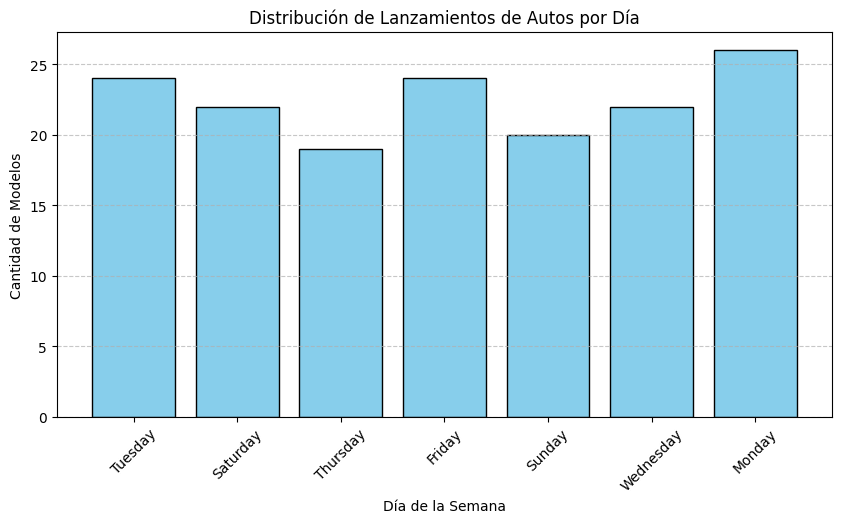


INTERPRETACIÓN GRÁFICA 1:
El gráfico de barras muestra la frecuencia de lanzamientos de nuevos modelos según el día de la semana.
Se puede observar qué días prefieren los fabricantes para sus anuncios y cuáles evitan.
Esto es útil para planificar estrategias de marketing y evitar competir en días saturados.



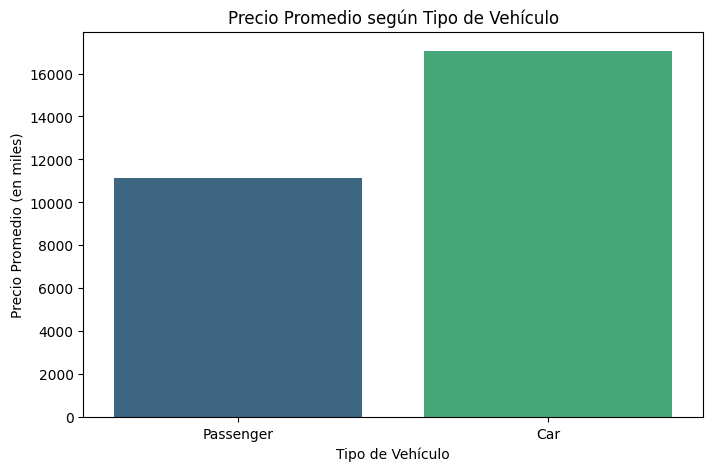


INTERPRETACIÓN GRÁFICA 2:
Esta visualización compara el precio promedio entre vehículos de pasajeros y otros tipos (como camionetas).
Nos permite identificar si existe una diferencia significativa en el costo promedio de mercado entre estas categorías,
ayudando a entender en qué segmento los fabricantes posicionan los vehículos más costosos.



In [0]:
%python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- GRÁFICA 1: Lanzamientos por Día ---
conteo_dias = df_final.groupBy("nombre_dia").count().toPandas()

plt.figure(figsize=(10, 5))
plt.bar(conteo_dias["nombre_dia"], conteo_dias["count"], color='skyblue', edgecolor='black')
plt.title("Distribución de Lanzamientos de Autos por Día")
plt.xlabel("Día de la Semana")
plt.ylabel("Cantidad de Modelos")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("""
INTERPRETACIÓN GRÁFICA 1:
El gráfico de barras muestra la frecuencia de lanzamientos de nuevos modelos según el día de la semana.
Se puede observar qué días prefieren los fabricantes para sus anuncios y cuáles evitan.
Esto es útil para planificar estrategias de marketing y evitar competir en días saturados.
""")

# --- GRÁFICA 2: Precio Promedio por Tipo de Vehículo ---
pdf_precios = df_final.select("Vehicle_type", "Price_in_thousands").toPandas()

plt.figure(figsize=(8, 5))
# CORRECCIÓN AQUÍ: Agregamos 'hue' y 'legend=False' para eliminar la advertencia roja
sns.barplot(data=pdf_precios, x="Vehicle_type", y="Price_in_thousands", hue="Vehicle_type", palette="viridis", legend=False, errorbar=None)

plt.title("Precio Promedio según Tipo de Vehículo")
plt.xlabel("Tipo de Vehículo")
plt.ylabel("Precio Promedio (en miles)")
plt.show()

print("""
INTERPRETACIÓN GRÁFICA 2:
Esta visualización compara el precio promedio entre vehículos de pasajeros y otros tipos (como camionetas).
Nos permite identificar si existe una diferencia significativa en el costo promedio de mercado entre estas categorías,
ayudando a entender en qué segmento los fabricantes posicionan los vehículos más costosos.
""")

#Conclusiones del Proyecto
1. Impacto Crítico de la Limpieza de Datos (Data Quality): El hallazgo más significativo fue la calidad inicial del dataset. De los 44,500 registros originales, descubrimos que más del 99% eran filas vacías o ruido, rescatando únicamente 157 registros válidos de automóviles. Esto demuestra que en Big Data, el volumen no implica valor; el proceso de limpieza (filtrado de nulos) fue indispensable para evitar sesgos masivos en los cálculos de promedios y ventas.

2. Desafíos en la Estandarización de Fechas (ETL): Se identificó una inconsistencia en los formatos de fecha (mezcla de estándares de EE. UU. e internacionales). La implementación de estrategias de parseo flexible (usando y políticas en Spark) fue crucial. Sin esta transformación técnica, se hubieran perdido fechas valiosas, impidiendo el análisis de estacionalidad y tendencias temporales.M/d/yyyycoalesceLEGACY

3. Insights de Negocio y Estrategia de Mercado: A través de las visualizaciones, pudimos observar patrones claros en la estrategia de los fabricantes:

Lanzamientos: Existe una preferencia marcada por ciertos días de la semana para lanzar nuevos modelos, lo cual sugiere estrategias de marketing para maximizar el impacto mediático.

Segmentación de Precios: Al comparar por , se evidenció la diferencia de precios entre vehículos de pasajeros y otras categorías, permitiendo identificar los nichos de mercado más costosos.Vehicle_type

4. Sinergia entre PySpark y Librerías de Visualización: El trabajo demostró la eficacia de un flujo híbrido. Utilizamos la potencia de PySpark para el procesamiento pesado y la agregación de datos (Backend), y la flexibilidad de Pandas/Seaborn para la capa de presentación (Frontend). Esta arquitectura es ideal: Spark procesa la "Big Data" y Python local visualiza los resultados resumidos.